In [ ]:
import os, json

KEYWORDS = ["wait", "alternatively", "hmm"]

def parse_result_file(file_stem: str, path: str, suffix: str = ".json", keywords=KEYWORDS):
    """
    读取单个 jsonl 文件，返回 dict:
      {"acc": float, "avg_len": float, "wait_count": int, "n": int}
    若文件不存在或有效样本为0，返回 None
    """
    file_path = os.path.join(path, file_stem + suffix)
    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        return None

    correct = 0
    total = 0
    total_len = 0
    total_keyword_count = 0

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            data = json.loads(line)

            # 跳过过短样本
            if data.get("len", 0) < 10:
                continue

            total += 1
            L = int(data.get("len", 0))
            total_len += L

            if data.get("correct", False):
                correct += 1

            text = (data.get("generated_text", "") or "").lower()
            for kw in keywords:
                total_keyword_count += text.count(kw)

    if total == 0:
        return None

    return {
        "acc": correct / total,
        "avg_len": total_len / total,
        "wait_count": total_keyword_count,
        "n": total,
    }


def parse_tag_budget(file_stem: str, model: str):
    """
    从 file_stem 里提取 (tag, budget)
    tag: begin / reason / less_think / standard
    budget: float
    兼容你原逻辑：*_False__budget1.0 视为 budget=0.0
    """
    # tag 判定（你之前的 special 点规则）
    if "begin" in file_stem:
        tag = "begin"
    elif "reason" in file_stem:
        tag = "reason"
    elif "less_think" in file_stem:
        tag = "less_think"
    else:
        tag = "standard"

    # budget 提取
    budget = None
    if "budget" in file_stem:
        try:
            budget = float(file_stem.split("budget")[-1])
        except Exception:
            budget = None

    # 特殊：False__budget1.0 => budget=0
    if "_False__budget1.0" in file_stem:
        budget = 0.0

    return tag, budget


def collect_results_dict(model: str, files, path: str, suffix: str = ".json", keywords=KEYWORDS):
    """
    输出 dict: results[(tag, budget)] = {"acc":..., "avg_len":..., "wait_count":..., "n":...}
    """
    results = {}
    for file_stem in files:
        metrics = parse_result_file(file_stem, path=path, suffix=suffix, keywords=keywords)
        if metrics is None:
            continue

        tag, budget = parse_tag_budget(file_stem, model=model)

        key = (tag, budget)
        if key in results:
            print(f"[WARN] duplicate key {key} from file {file_stem}. Overwriting.")
        results[key] = metrics

        print(f"{key} -> acc={metrics['acc']:.3f}, avg_len={metrics['avg_len']:.1f}, wait={metrics['wait_count']}  ({file_stem})")

    return results

In [ ]:
import matplotlib.pyplot as plt

def plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",                 # "acc" / "avg_len" / "wait_count"
    title=None,
    xlabel="Reasoning Budget",
    ylabel=None,
    save_path=None,
    dpi=300
):
    ref_key = ("standard", 1.0)
    if ref_key not in results_dict:
        raise KeyError(f"Missing {ref_key} in results_dict (needed for normalization).")
    ref_len = float(results_dict[ref_key]["avg_len"])

    std_points = []
    for (fmt, b), v in results_dict.items():
        if fmt != "standard":
            continue
        b = float(b)
        y = float(v[y_key])

        if b == 0.0:
            x = 0.0
        elif b == 1.0:
            x = 1.0
        else:
            x = float(v["avg_len"]) / ref_len

        std_points.append((x, y, b))

    std_points.sort(key=lambda t: t[0])
    x_std = [t[0] for t in std_points]
    y_std = [t[1] for t in std_points]

    other_points = {}
    for (fmt, b), v in results_dict.items():
        if fmt == "standard":
            continue
        x = float(v["avg_len"]) / ref_len
        y = float(v[y_key])
        other_points.setdefault(fmt, []).append((x, y))

    fig, ax = plt.subplots(figsize=(4.5, 2.3))

    ax.plot(
        x_std, y_std,
        linewidth=2.2,
        marker="o",
        markersize=8.5,          
        label="standard"
    )

    marker_map = {"begin": "D", "reason": "s", "less_think": "^"}
    red_color = "#d62728"

    for fmt, pts in other_points.items():
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        ax.scatter(
            xs, ys,
            s=120,               
            marker=marker_map.get(fmt, "o"),
            color=red_color,
            edgecolors="black",
            linewidths=1.0,     
            label=fmt,
            zorder=3
        )

    if ylabel is None:
        ylabel = {
            "acc": "Accuracy",
            "avg_len": "Avg. Output Length",
            "wait_count": "Wait Count"
        }.get(y_key, y_key)

    ax.set_xlabel(xlabel, fontsize=12, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
    if title:
        ax.set_title(title, fontsize=12, fontweight="bold")

    ax.tick_params(axis="both", labelsize=11)
    ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    all_y = list(y_std)
    for pts in other_points.values():
        all_y.extend([p[1] for p in pts])

    y_min, y_max = min(all_y), max(all_y)
    pad = 0.08 * (y_max - y_min) if y_max > y_min else 0.02
    ax.set_ylim(y_min - pad, y_max + pad)

    # ax.legend(fontsize=10, frameon=False, loc="lower right")
    ax.legend(
        fontsize=10,
        frameon=False,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.95),
        ncol=4,
        handletextpad=0.4,
        columnspacing=1.0
    )

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", dpi=dpi)

    return fig, ax

## MATH500

('begin', 1.0) -> acc=0.931, avg_len=2805.5, wait=23024  (Qwen3-14B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.921, avg_len=2589.8, wait=20933  (Qwen3-14B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.933, avg_len=2655.0, wait=21249  (Qwen3-14B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.863, avg_len=899.1, wait=329  (Qwen3-14B_False__budget1.0)
('standard', 0.1) -> acc=0.874, avg_len=1563.3, wait=10252  (Qwen3-14B_True__budget0.1)
('standard', 0.2) -> acc=0.892, avg_len=1879.9, wait=16225  (Qwen3-14B_True__budget0.2)
('standard', 0.3) -> acc=0.916, avg_len=2170.8, wait=22293  (Qwen3-14B_True__budget0.3)
('standard', 0.4) -> acc=0.922, avg_len=2472.7, wait=27339  (Qwen3-14B_True__budget0.4)
('standard', 0.5) -> acc=0.928, avg_len=2852.9, wait=33080  (Qwen3-14B_True__budget0.5)
('standard', 0.6) -> acc=0.936, avg_len=3244.6, wait=38788  (Qwen3-14B_True__budget0.6)
('standard', 1.0) -> acc=0.944, avg_len=4904.3, wait=59288  (Qwen3-14B_True__budget1.0)


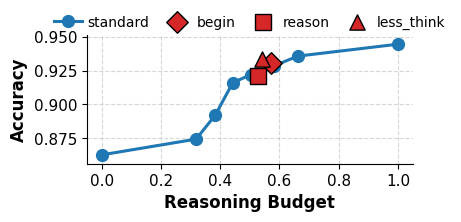

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "MATH-500", 5, "Qwen3-14B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

('begin', 1.0) -> acc=0.875, avg_len=2883.0, wait=27672  (Qwen3-8B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.903, avg_len=2831.7, wait=25570  (Qwen3-8B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.912, avg_len=2752.8, wait=24833  (Qwen3-8B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.832, avg_len=1012.6, wait=2082  (Qwen3-8B_False__budget1.0)
('standard', 0.1) -> acc=0.880, avg_len=2145.3, wait=19679  (Qwen3-8B_True__budget0.1)
('standard', 0.2) -> acc=0.898, avg_len=2466.6, wait=26778  (Qwen3-8B_True__budget0.2)
('standard', 0.3) -> acc=0.903, avg_len=2709.0, wait=33543  (Qwen3-8B_True__budget0.3)
('standard', 0.4) -> acc=0.920, avg_len=3085.2, wait=40188  (Qwen3-8B_True__budget0.4)
('standard', 0.5) -> acc=0.928, avg_len=3456.7, wait=52871  (Qwen3-8B_True__budget0.5)
('standard', 0.6) -> acc=0.933, avg_len=3788.3, wait=53260  (Qwen3-8B_True__budget0.6)
('standard', 1.0) -> acc=0.946, avg_len=5557.4, wait=81367  (Qwen3-8B_True__budget1.0)


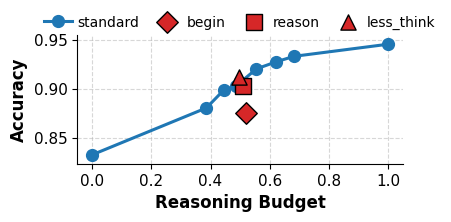

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "MATH-500", 5, "Qwen3-8B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

('begin', 1.0) -> acc=0.866, avg_len=2260.2, wait=20497  (Qwen3-4B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.879, avg_len=2269.7, wait=18879  (Qwen3-4B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.895, avg_len=2339.6, wait=20966  (Qwen3-4B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.832, avg_len=991.2, wait=537  (Qwen3-4B_False__budget1.0)
('standard', 0.1) -> acc=0.886, avg_len=2436.2, wait=27413  (Qwen3-4B_True__budget0.1)
('standard', 0.2) -> acc=0.886, avg_len=2491.1, wait=28826  (Qwen3-4B_True__budget0.2)
('standard', 0.3) -> acc=0.907, avg_len=2736.9, wait=35522  (Qwen3-4B_True__budget0.3)
('standard', 0.4) -> acc=0.914, avg_len=2996.4, wait=40551  (Qwen3-4B_True__budget0.4)
('standard', 0.5) -> acc=0.923, avg_len=3362.2, wait=48079  (Qwen3-4B_True__budget0.5)
('standard', 0.6) -> acc=0.925, avg_len=3734.0, wait=56438  (Qwen3-4B_True__budget0.6)
('standard', 1.0) -> acc=0.940, avg_len=5334.5, wait=80918  (Qwen3-4B_True__budget1.0)


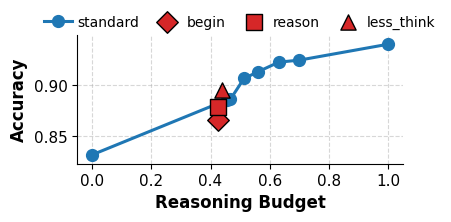

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "MATH-500", 5, "Qwen3-4B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

## AIME

('begin', 1.0) -> acc=0.613, avg_len=11717.4, wait=17083  (Qwen3-14B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.587, avg_len=10862.2, wait=14660  (Qwen3-14B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.611, avg_len=10747.9, wait=14893  (Qwen3-14B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.229, avg_len=4084.9, wait=501  (Qwen3-14B_False__budget1.0)
('standard', 0.1) -> acc=0.331, avg_len=5884.0, wait=7070  (Qwen3-14B_True__budget0.1)
('standard', 0.2) -> acc=0.378, avg_len=6515.3, wait=10911  (Qwen3-14B_True__budget0.2)
('standard', 0.3) -> acc=0.429, avg_len=7784.5, wait=14455  (Qwen3-14B_True__budget0.3)
('standard', 0.4) -> acc=0.489, avg_len=8626.4, wait=17597  (Qwen3-14B_True__budget0.4)
('standard', 0.5) -> acc=0.547, avg_len=9449.8, wait=20143  (Qwen3-14B_True__budget0.5)
('standard', 0.6) -> acc=0.576, avg_len=10486.8, wait=21793  (Qwen3-14B_True__budget0.6)
('standard', 1.0) -> acc=0.744, avg_len=15792.0, wait=31686  (Qwen3-14B_True__budget1.0)


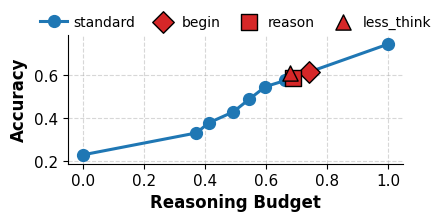

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "aimo-validation-aime", 5, "Qwen3-14B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

('begin', 1.0) -> acc=0.542, avg_len=11572.0, wait=16105  (Qwen3-8B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.504, avg_len=11829.9, wait=15345  (Qwen3-8B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.527, avg_len=11248.9, wait=15382  (Qwen3-8B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.213, avg_len=4520.2, wait=447  (Qwen3-8B_False__budget1.0)
('standard', 0.1) -> acc=0.442, avg_len=8186.6, wait=13033  (Qwen3-8B_True__budget0.1)
('standard', 0.2) -> acc=0.416, avg_len=9176.0, wait=17828  (Qwen3-8B_True__budget0.2)
('standard', 0.3) -> acc=0.464, avg_len=9764.1, wait=22225  (Qwen3-8B_True__budget0.3)
('standard', 0.4) -> acc=0.542, avg_len=10884.7, wait=25766  (Qwen3-8B_True__budget0.4)
('standard', 0.5) -> acc=0.549, avg_len=12336.6, wait=29276  (Qwen3-8B_True__budget0.5)
('standard', 0.6) -> acc=0.611, avg_len=12561.1, wait=30263  (Qwen3-8B_True__budget0.6)
('standard', 1.0) -> acc=0.716, avg_len=16846.9, wait=40342  (Qwen3-8B_True__budget1.0)


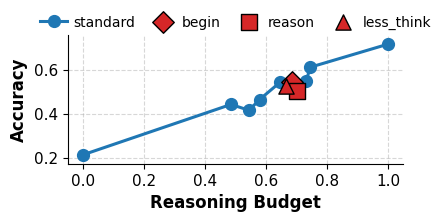

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "aimo-validation-aime", 5, "Qwen3-8B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

('begin', 1.0) -> acc=0.442, avg_len=10279.7, wait=13432  (Qwen3-4B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.429, avg_len=10902.6, wait=13153  (Qwen3-4B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.456, avg_len=11047.5, wait=14965  (Qwen3-4B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.200, avg_len=4605.1, wait=542  (Qwen3-4B_False__budget1.0)
('standard', 0.1) -> acc=0.389, avg_len=8416.7, wait=14043  (Qwen3-4B_True__budget0.1)
('standard', 0.2) -> acc=0.418, avg_len=8436.9, wait=17443  (Qwen3-4B_True__budget0.2)
('standard', 0.3) -> acc=0.440, avg_len=8899.7, wait=19193  (Qwen3-4B_True__budget0.3)
('standard', 0.4) -> acc=0.476, avg_len=10061.0, wait=23875  (Qwen3-4B_True__budget0.4)
('standard', 0.5) -> acc=0.482, avg_len=10718.2, wait=26805  (Qwen3-4B_True__budget0.5)
('standard', 0.6) -> acc=0.538, avg_len=11674.0, wait=29627  (Qwen3-4B_True__budget0.6)
('standard', 1.0) -> acc=0.687, avg_len=16699.5, wait=40089  (Qwen3-4B_True__budget1.0)


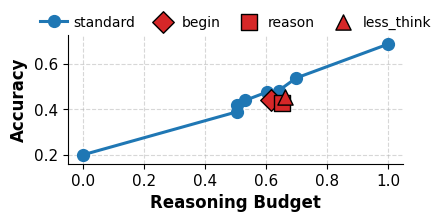

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "aimo-validation-aime", 5, "Qwen3-4B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

## GPQA

('begin', 1.0) -> acc=0.504, avg_len=2160.2, wait=6138  (Qwen3-14B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.539, avg_len=1763.0, wait=4159  (Qwen3-14B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.504, avg_len=2073.1, wait=4999  (Qwen3-14B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.394, avg_len=1211.4, wait=398  (Qwen3-14B_False__budget1.0)
('standard', 0.1) -> acc=0.415, avg_len=1756.2, wait=7836  (Qwen3-14B_True__budget0.1)
('standard', 0.2) -> acc=0.417, avg_len=2351.2, wait=13849  (Qwen3-14B_True__budget0.2)
('standard', 0.3) -> acc=0.420, avg_len=3005.8, wait=20242  (Qwen3-14B_True__budget0.3)
('standard', 0.4) -> acc=0.477, avg_len=3606.8, wait=25896  (Qwen3-14B_True__budget0.4)
('standard', 0.5) -> acc=0.469, avg_len=4208.1, wait=30162  (Qwen3-14B_True__budget0.5)
('standard', 0.6) -> acc=0.474, avg_len=5000.8, wait=35780  (Qwen3-14B_True__budget0.6)
('standard', 1.0) -> acc=0.631, avg_len=7799.4, wait=50661  (Qwen3-14B_True__budget1.0)


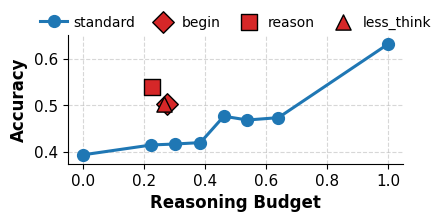

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "gpqa", 5, "Qwen3-14B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

('begin', 1.0) -> acc=0.401, avg_len=2216.2, wait=4010  (Qwen3-8B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.395, avg_len=2084.0, wait=2691  (Qwen3-8B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.428, avg_len=2611.1, wait=8457  (Qwen3-8B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.376, avg_len=1344.9, wait=459  (Qwen3-8B_False__budget1.0)
('standard', 0.1) -> acc=0.327, avg_len=2417.5, wait=12321  (Qwen3-8B_True__budget0.1)
('standard', 0.2) -> acc=0.340, avg_len=2997.6, wait=20754  (Qwen3-8B_True__budget0.2)
('standard', 0.3) -> acc=0.351, avg_len=3690.9, wait=28791  (Qwen3-8B_True__budget0.3)
('standard', 0.4) -> acc=0.336, avg_len=4419.2, wait=36001  (Qwen3-8B_True__budget0.4)
('standard', 0.5) -> acc=0.343, avg_len=5056.5, wait=43296  (Qwen3-8B_True__budget0.5)
('standard', 0.6) -> acc=0.365, avg_len=5925.4, wait=51172  (Qwen3-8B_True__budget0.6)
('standard', 1.0) -> acc=0.609, avg_len=9007.9, wait=71817  (Qwen3-8B_True__budget1.0)


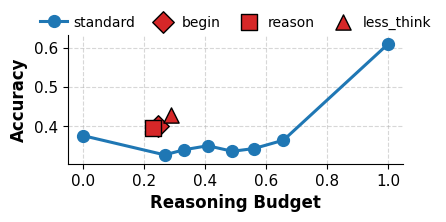

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "gpqa", 5, "Qwen3-8B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

('begin', 1.0) -> acc=0.401, avg_len=2492.8, wait=2800  (Qwen3-4B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.387, avg_len=2616.3, wait=2672  (Qwen3-4B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.382, avg_len=2905.3, wait=4208  (Qwen3-4B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.369, avg_len=1559.7, wait=590  (Qwen3-4B_False__budget1.0)
('standard', 0.1) -> acc=0.383, avg_len=2197.6, wait=11266  (Qwen3-4B_True__budget0.1)
('standard', 0.2) -> acc=0.354, avg_len=2740.3, wait=19324  (Qwen3-4B_True__budget0.2)
('standard', 0.3) -> acc=0.379, avg_len=3500.9, wait=28245  (Qwen3-4B_True__budget0.3)
('standard', 0.4) -> acc=0.410, avg_len=4256.3, wait=35742  (Qwen3-4B_True__budget0.4)
('standard', 0.5) -> acc=0.388, avg_len=4965.4, wait=42606  (Qwen3-4B_True__budget0.5)
('standard', 0.6) -> acc=0.451, avg_len=5684.2, wait=49076  (Qwen3-4B_True__budget0.6)
('standard', 1.0) -> acc=0.532, avg_len=8729.2, wait=72509  (Qwen3-4B_True__budget1.0)


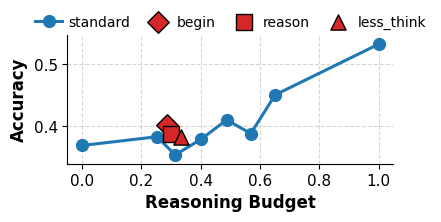

In [ ]:
# -------------------- usage --------------------
dataset, n, model = "gpqa", 5, "Qwen3-4B"
path = os.path.join("/expert/no_think_hybrid", dataset, str(n))

files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()